# Data Preparation Notebook

**Goal**: The aim of this notebook is to combine, filter, and merge the data, preparing it for further analysis and modeling.

**Output**: The prepared data, named `propertySalesPrep` (CSV and SHP formats), ready for subsequent analysis and modeling.

**Table of Content**
- [1 Library](#1-Library)
- [2 Load Data](#2-Load-Data)
- [3 Preparation](#3-Preparation)
    - [3.1 PropertySales Data Preparation](#3.1-PropertySales-Data-Preparation)
    - [3.2 Convert Dataframe to Geodataframe](#3.2-Convert-Dataframe-to-Geodataframe)
    - [3.3 Merge propertySales with BBL to Convert to Geospatial Data](#3.3-Merge-propertySales-with-BBL-to-Convert-to-Geospatial-Data)
    - [3.4 Buffer and Intersect](#3.4-Buffer-and-Intersect)
- [4 Export Data](#4-Export-Data)

<span style="color:red"> <strong>Warning: </strong> </span> Due to the large size of the data, running this notebook may take approximately 5 minutes.

___
# 1 Library

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from shapely.geometry import Point
import os  
import urllib.request
import warnings 
warnings.filterwarnings('ignore')

# 2 Load Data

<span style="color:blue"> <strong>Must Read!</strong> </span>

Please ensure to download the datasets from [this Google Drive link](https://drive.google.com/drive/folders/15nctGhM77FwRKYvDApmcnvpSH6bqBHzl?usp=sharing) and save them in the same directory where your notebook is located, before proceeding to load the dataset.

```
├── dataset
│   ├── raw
│   ├ ├── Infrastructure Data
│   ├ ├── NYC Core Data Website
│   ├ ├── Rolling Sale
│   ├ ├── Zip Code
│   ├ ├── Zoning
│   ├ ├── BBL.csv
│   ├── processed
├── your_notebook1.ipynb
├── your_notebook2.ipynb
```

**The datasets**

| Dataset  | Source  |  Variable Name in Notebook | Category  |   |
|---|---|---|---|---|
|  Property Sales (2011-2022) |  [NYC Department of Finance](https://www.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) | propertySales  | Housing  |   |
|  School Location |  [NYC Open Data](https://data.cityofnewyork.us/Education/2019-2020-School-Locations/wg9x-4ke6) |  school_location | Infrastructure  |   |
|  Bus Stop Shelter | [NYC Open Data](https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz)  | bus_stop_shelter  | Infrastructure  |   |
|  Health Facility | [HEALTH.DATA.NY.GOV](https://health.data.ny.gov/Health/Health-Facility-Map/875v-tpc8)  | health_facility_map  |  Infrastructure |   |
|  Park Properties |  [NYC Open Data](https://shorturl.at/lqLU1) | park_properties  | Infrastructure  |   |
|  Park Zones | [NYC Open Data](https://shorturl.at/fgtX6) | parks_zones  | Infrastructure  |   |
|  NYC Core Data | Many links from [NYC Core](https://coredata.nyc/) | df_nyc_core  |   |   |
| PLUTO (Land Use) |  [NYC Planning](https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)|  pluto_23v3 | Geographic (Land Use)  |   |
|  NYC Zip Code |  [NYC Open Data](https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip) | zipcode  | Spatial Administrative  |   |
|  BBL (Borough, Block, Lot) | [NYC Open Data](https://dropbox.com/s/l8q8xm82wkhytod/BBL.csv?dl=1)  | BBL  |  Spatial Administrative |   |
|  Neighborhood | [NYC Open Data](https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON)  | neighborhood  | Spatial Administrative  |   |

In [2]:
# Load property sales data from 2015 to 2022
directory = 'dataset/raw/Rolling Sale/'
files = os.listdir(directory)
propertySalesRaw = None

for file in files[21:]:
    if '.xls' in file:
        # Extract the year from the filename
        year = int(file[:4])
        # Determine the number of rows to skip
        skiprows = 4 if year < 2020 else 6
        # Construct the full file path
        file_path = os.path.join(directory, file)
        # Read the file with appropriate skiprows
        df = pd.read_excel(file_path, skiprows=skiprows)
        df.columns = [name.replace('\n', ' ').replace('  ', ' ').strip() for name in df.columns]
        # Concatenate data
        propertySalesRaw = pd.concat([propertySalesRaw, df], ignore_index=True) if propertySalesRaw is not None else df

In [3]:
# Load infrastructure data
school_location = pd.read_csv('dataset/raw/Infrastructure Data/2019_-_2020_School_Locations_20231203.csv')
bus_stop_shelter = pd.read_csv('dataset/raw/Infrastructure Data/Bus_Stop_Shelter.csv')
health_facility_map = pd.read_csv('dataset/raw/Infrastructure Data/Health_Facility_Map.csv')
subway_entrance = gpd.read_file('dataset/raw/Infrastructure Data/DOITT_SUBWAY_ENTRANCE/DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.shp')
parks_properties = gpd.read_file('dataset/raw/Infrastructure Data/Parks Properties.geojson')
parks_zones = gpd.read_file('dataset/raw/Infrastructure Data/Parks Zones.geojson')

# Load pluto data
pluto_23v3 = pd.read_csv('dataset/raw/Zoning/pluto_23v3.csv')

Cannot find header.dxf (GDAL_DATA is not defined)


In [4]:
# Load spatial data: Zip Code
zipcode = gpd.read_file('dataset/raw/Zip Code/ZIP_CODE_040114.shp')
zipcode = zipcode.to_crs({'init': 'epsg:4326'})

# Load spatial data: BBL
BBL = pd.read_csv('dataset/raw/BBL.csv', on_bad_lines='skip')
BBL = BBL[['borough', 'block', 'lot','latitude', 'longitude']]

# Load spatial data: neighborhood map
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
urllib.request.urlretrieve(url, 'Data/neighborhood.geojson')
neighborhood = gpd.read_file('Data/neighborhood.geojson')
neighborhood = neighborhood[['ntacode','geometry']]

# 3 Preparation

## 3.1 PropertySales Data Preparation

In [6]:
# Select only relevant columns
selected_var = [ 'ZIP CODE', 'BOROUGH','BLOCK','LOT', 'ADDRESS', 'BUILDING CLASS CATEGORY',
                'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE DATE','SALE PRICE']
propertySales = propertySalesRaw[selected_var]

# Standardized columns
propertySales.columns = propertySales.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [7]:
# Filter data (include only data that has plausible value)
propertySales = propertySales[(propertySales['year_built'] >= 1850) & (propertySales['gross_square_feet'] >=300) 
                                & (propertySales['gross_square_feet'] <1e5) & (propertySales['sale_price'] >= 1e4) 
                                & (propertySales['sale_price'] <= 5e8)]
propertySales = propertySales[propertySales['sale_date'] > '2015-12-31']

In [8]:
# Remove white spaces in building_class_category
propertySales['building_class_category'] = propertySales['building_class_category'].str.replace(r'\s+', ' ', 
                                                                                                regex=True).str.strip()

In [9]:
# Split building class category to two parts
propertySales.insert(6, 'category_id', propertySales['building_class_category'].apply(lambda x: x[:2]))
propertySales.insert(7, 'building_class_name', propertySales['building_class_category'].apply(lambda x: x.split(' ',1)[1]).apply(lambda x:x.strip()))

In [10]:
# Select Zip Code that exists in zipcode dataframe
zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)
NYC_zipcode = zipcode['ZIPCODE'].unique()
propertySales = propertySales[propertySales['zip_code'].isin(NYC_zipcode)]

In [11]:
# Convert zipcode data types into string
propertySales['borough'] = propertySales['borough'].astype('int')
propertySales['block'] = propertySales['block'].astype('int')
propertySales['lot'] = propertySales['lot'].astype('int')
propertySales['zip_code'] = propertySales['zip_code'].astype('int')
propertySales['borough'] = propertySales['borough'].astype('str')
propertySales['block'] = propertySales['block'].astype('str')
propertySales['lot'] = propertySales['lot'].astype('str')

In [12]:
# Display data
propertySales

,zip_code,borough,block,lot,address,building_class_category,category_id,building_class_name,gross_square_feet,year_built,sale_date,sale_price
84711,10457,2,3043,55,1948 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,2047.0,1901.0,2016-06-22,220000.0
84712,10457,2,3046,52,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,1901.0,2016-09-21,273796.0
84713,10457,2,3046,52,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,1901.0,2016-09-21,231244.0
84716,10457,2,3048,28,540 EAST 182 STREET,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1048.0,1901.0,2016-09-27,290000.0
84719,10457,2,2900,61,406 EAST TREMONT AVENUE,02 TWO FAMILY DWELLINGS,02,TWO FAMILY DWELLINGS,4452.0,1931.0,2016-02-24,399000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
666003,11377,4,1321,7,43-27 52ND STREET,29 COMMERCIAL GARAGES,29,COMMERCIAL GARAGES,1670.0,1931.0,2022-09-13,2050000.0
666006,11377,4,1199,7,60-05 37TH AVENUE,30 WAREHOUSES,30,WAREHOUSES,6800.0,1964.0,2022-03-30,3450000.0
666007,11377,4,1208,22,55-07 39TH AVENUE,30 WAREHOUSES,30,WAREHOUSES,5000.0,1954.0,2022-01-06,2500000.0
666008,11377,4,1308,46,41-32 69TH STREET,37 RELIGIOUS FACILITIES,37,RELIGIOUS FACILITIES,2400.0,1925.0,2022-03-15,1200000.0


## 3.2 Convert Dataframe to Geodataframe

school_location, bus_stop_shelter, and health_facility_map have latitude and longitude column but have note been converted into Geodataframe. So, we will conver them into Geodataframe

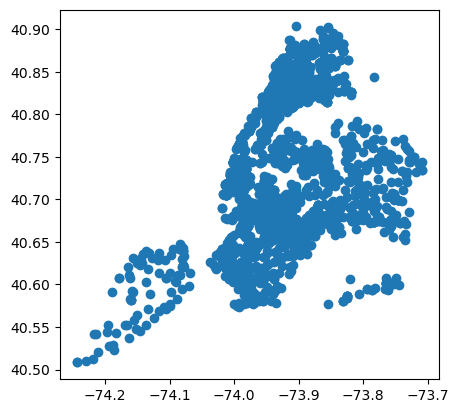

In [13]:
# Converting school_location dataframe to geodataframe
geometry = [Point(xy) for xy in zip(school_location['LONGITUDE'], school_location['LATITUDE'])]
school_location_gdf = gpd.GeoDataFrame(school_location, crs="EPSG:4326", geometry=geometry)
school_location_gdf = school_location_gdf[school_location_gdf['LATITUDE'] > 0]
school_location_gdf.plot();

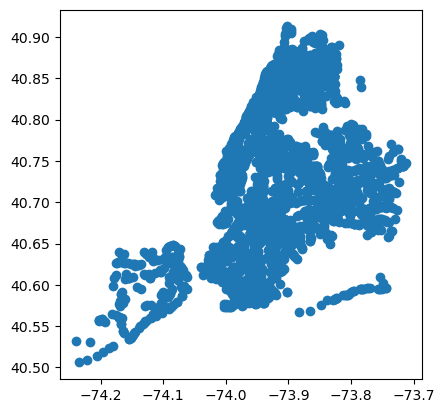

In [14]:
# Converting bus_stop_shelter dataframe to geodataframe
geometry = [Point(xy) for xy in zip(bus_stop_shelter['Longitude'], bus_stop_shelter['Latitude'])]
bus_stop_shelter_gdf = gpd.GeoDataFrame(bus_stop_shelter, crs="EPSG:4326", geometry=geometry)
bus_stop_shelter_gdf.plot();

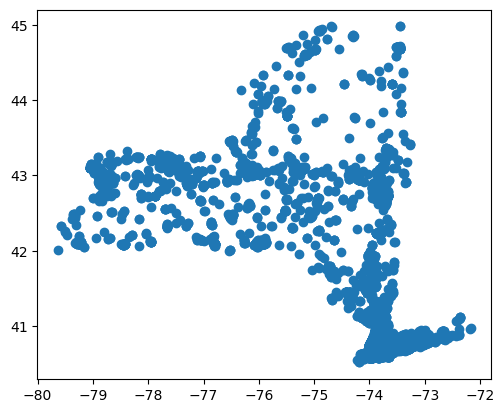

In [15]:
# Converting health_facility_map dataframe to geodataframe
geometry = [Point(xy) for xy in zip(health_facility_map['Facility Longitude'], health_facility_map['Facility Latitude'])]
health_facility_map_gdf = gpd.GeoDataFrame(health_facility_map, crs="EPSG:4326", geometry=geometry)
health_facility_map_gdf.plot();

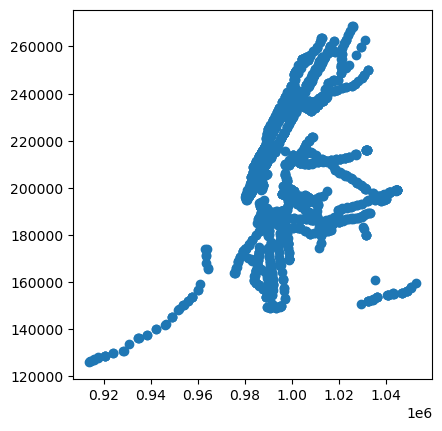

In [16]:
# Plot subway entrance
subway_entrance.plot();

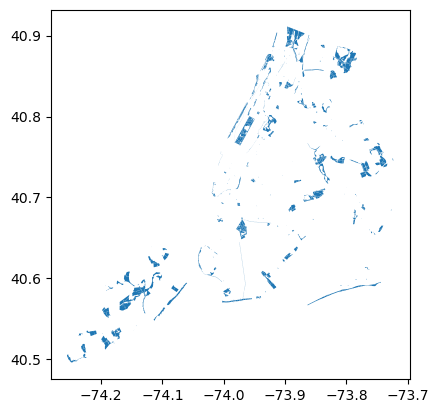

In [17]:
# Plot park zones
parks_zones.plot();

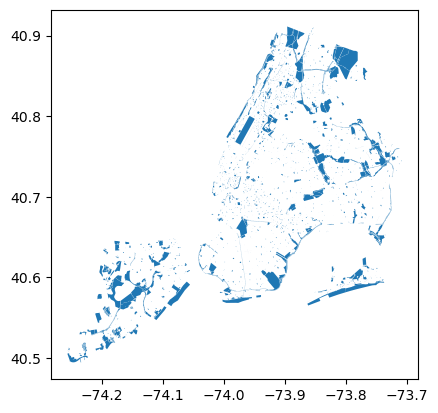

In [18]:
# Plot park properties
parks_properties.plot();

In [19]:
# # Plot pluto
# pluto_23v3_gdf = gpd.GeoDataFrame(pluto_23v3,
#                                   geometry=gpd.points_from_xy(pluto_23v3['longitude'], pluto_23v3['latitude']), 
#                                   crs="EPSG:4326")
# pluto_23v3_gdf.plot();

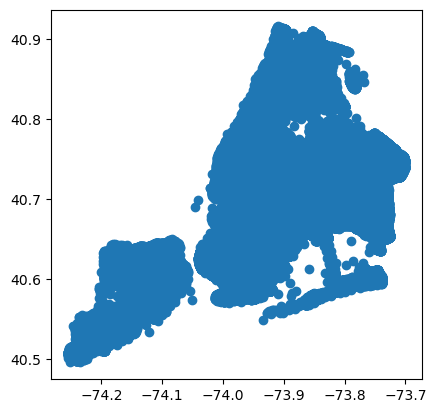

In [20]:
# Add geometry column to BBL data
geometry = [Point(xy) for xy in zip(BBL['longitude'], BBL['latitude'])]
BBL = gpd.GeoDataFrame(BBL, geometry=geometry,crs={'init': 'epsg:4326'})
BBL.plot();

## 3.3 Merge propertySales with BBL to Convert to Geospatial Data

In [21]:
# Change borough name to code
BoroCode = {'BK':'3', 'QN':'4', 'BX':'2', 'SI':'5', 'MN':'1'}
BBL['borough_name'] = BBL['borough']
BBL['borough'] = BBL.borough.apply(lambda x: BoroCode[x] if x in BoroCode else np.nan)
BBL.dropna(inplace=True)

# Convert BBL column to str
BBL['borough'] = BBL['borough'].astype('str')
BBL['block'] = BBL['block'].astype('str')
BBL['lot'] = BBL['lot'].astype('str')

In [22]:
# Merge BBL propertySales and data
propertySalesCompleteGeo =  BBL.merge(propertySales, on=['borough','block','lot'], how='right')
propertySalesCompleteGeo.dropna(inplace=True)

In [23]:
# # Convert borough code to borough name
# borocode = {'Manhattan':1, 'Bronx':2, 'Brooklyn':3, 'Queens':4, 'Staten Island':5}
# propertySales.insert(1, 'borough_code', propertySales['borough'].apply(lambda x: borocode[x] if x in borocode else np.nan))
# propertySales['borough_code'] = propertySales['borough_code'].astype('str')
# propertySales

In [24]:
# Display data
print(propertySalesCompleteGeo.columns)
propertySalesCompleteGeo

Index(['borough', 'block', 'lot', 'latitude', 'longitude', 'geometry',
       'borough_name', 'zip_code', 'address', 'building_class_category',
       'category_id', 'building_class_name', 'gross_square_feet', 'year_built',
       'sale_date', 'sale_price'],
      dtype='object')


,borough,block,lot,latitude,longitude,geometry,borough_name,zip_code,address,building_class_category,category_id,building_class_name,gross_square_feet,year_built,sale_date,sale_price
0,2,3043,55,40.847655,-73.896431,POINT (-73.89643 40.84766),BX,10457,1948 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,2047.0,1901.0,2016-06-22,220000.0
1,2,3046,52,40.850141,-73.895618,POINT (-73.89562 40.85014),BX,10457,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,1901.0,2016-09-21,273796.0
2,2,3046,52,40.850141,-73.895618,POINT (-73.89562 40.85014),BX,10457,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,1901.0,2016-09-21,231244.0
3,2,3048,28,40.852886,-73.892805,POINT (-73.89280 40.85289),BX,10457,540 EAST 182 STREET,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1048.0,1901.0,2016-09-27,290000.0
4,2,2900,61,40.847395,-73.900693,POINT (-73.90069 40.84740),BX,10457,406 EAST TREMONT AVENUE,02 TWO FAMILY DWELLINGS,02,TWO FAMILY DWELLINGS,4452.0,1931.0,2016-02-24,399000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187072,4,1321,7,40.743102,-73.912429,POINT (-73.91243 40.74310),QN,11377,43-27 52ND STREET,29 COMMERCIAL GARAGES,29,COMMERCIAL GARAGES,1670.0,1931.0,2022-09-13,2050000.0
187073,4,1199,7,40.749852,-73.902225,POINT (-73.90222 40.74985),QN,11377,60-05 37TH AVENUE,30 WAREHOUSES,30,WAREHOUSES,6800.0,1964.0,2022-03-30,3450000.0
187074,4,1208,22,40.748723,-73.907557,POINT (-73.90756 40.74872),QN,11377,55-07 39TH AVENUE,30 WAREHOUSES,30,WAREHOUSES,5000.0,1954.0,2022-01-06,2500000.0
187075,4,1308,46,40.743561,-73.896084,POINT (-73.89608 40.74356),QN,11377,41-32 69TH STREET,37 RELIGIOUS FACILITIES,37,RELIGIOUS FACILITIES,2400.0,1925.0,2022-03-15,1200000.0


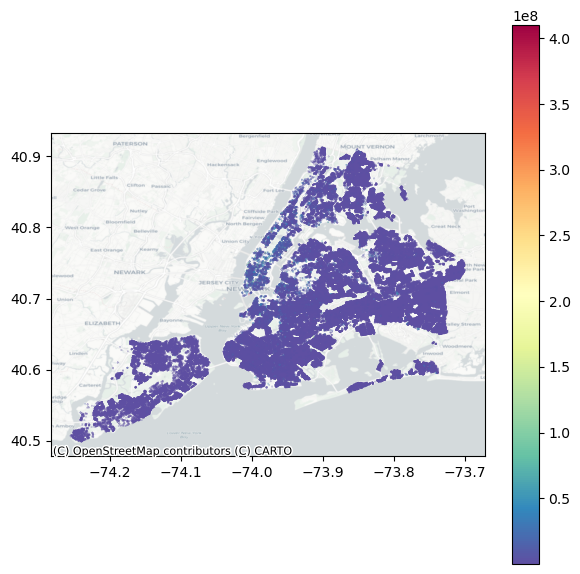

In [25]:
# Plot propertySalesCompleteGeo data (sale price as color)
import contextily as cx

ax = propertySalesCompleteGeo.plot(column='sale_price', colormap='Spectral_r', legend=True,
                                   markersize=0.025,  figsize=(7,7)
                                  )
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="epsg:4326");

## 3.4 Buffer and Intersect

In [26]:
# Copy Dataframe
property_listings = propertySalesCompleteGeo.copy()

In [27]:
# Convert datasets CRS to UTM
property_listings_utm = propertySalesCompleteGeo.to_crs(epsg=32618)
subway_stations_utm = subway_entrance.to_crs(epsg=32618)
school_location_utm = school_location_gdf.to_crs(epsg=32618)
bus_stop_shelter_utm = bus_stop_shelter_gdf.to_crs(epsg=32618)
health_facility_map_utm = health_facility_map_gdf.to_crs(epsg=32618)
parks_properties_utm = parks_properties.to_crs(epsg=32618)
parks_zones_utm = parks_zones.to_crs(epsg=32618)

In [28]:
# Create a 1000 meters (1 km) buffer around each property listing
buffered = property_listings_utm.buffer(1000)

In [29]:
# Change geometry column name and make buffered variable to be the geometry column
property_listings_utm = property_listings_utm.rename(columns={"geometry": "point_geometry"})
property_listings_utm['geometry'] = buffered

In [30]:
# Perform a spatial join between the buffered listings and infrastructure data
subway_within_buffer = gpd.sjoin(subway_stations_utm, property_listings_utm, how='inner', op='intersects')
schools_within_buffer = gpd.sjoin(school_location_utm, property_listings_utm, how='inner', op='intersects')
bus_within_buffer = gpd.sjoin(bus_stop_shelter_utm, property_listings_utm, how='inner', op='intersects')
health_within_buffer = gpd.sjoin(health_facility_map_utm, property_listings_utm, how='inner', op='intersects')
parkproperties_within_buffer = gpd.sjoin(parks_properties_utm, property_listings_utm, how='inner', op='intersects')
parkzones_within_buffer = gpd.sjoin(parks_zones_utm, property_listings_utm, how='inner', op='intersects')

In [31]:
# Count the number of infrastuctures within each buffer
counts_subway = subway_within_buffer.groupby('index_right').size()
counts_schools = schools_within_buffer.groupby('index_right').size()  
counts_bus = bus_within_buffer.groupby('index_right').size()  
counts_health = health_within_buffer.groupby('index_right').size()  
counts_parkproperties = parkproperties_within_buffer.groupby('index_right').size()  
counts_parkzones = parkzones_within_buffer.groupby('index_right').size()  

In [32]:
# Create new columns with the number of infrastructures within 1 km
property_listings['subway_count_in_1km'] = property_listings_utm.index.map(counts_subway).fillna(0)
property_listings['bus_count_in_1km'] = property_listings_utm.index.map(counts_schools).fillna(0)
property_listings['schools_count_in_1km'] = property_listings_utm.index.map(counts_bus).fillna(0)
property_listings['health_facil_count_in_1km'] = property_listings_utm.index.map(counts_health).fillna(0)
property_listings['park_properties_count_in_1km'] = property_listings_utm.index.map(counts_parkproperties).fillna(0)
property_listings['park_zones_count_in_1km'] = property_listings_utm.index.map(counts_parkzones).fillna(0)

In [33]:
property_listings

,borough,block,lot,latitude,longitude,geometry,borough_name,zip_code,address,building_class_category,...,gross_square_feet,year_built,sale_date,sale_price,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km
0,2,3043,55,40.847655,-73.896431,POINT (-73.89643 40.84766),BX,10457,1948 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,...,2047.0,1901.0,2016-06-22,220000.0,7.0,36.0,17.0,29.0,43.0,16.0
1,2,3046,52,40.850141,-73.895618,POINT (-73.89562 40.85014),BX,10457,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,...,1431.0,1901.0,2016-09-21,273796.0,9.0,45.0,19.0,31.0,41.0,8.0
2,2,3046,52,40.850141,-73.895618,POINT (-73.89562 40.85014),BX,10457,2047 BATHGATE AVENUE,01 ONE FAMILY DWELLINGS,...,1431.0,1901.0,2016-09-21,231244.0,9.0,45.0,19.0,31.0,41.0,8.0
3,2,3048,28,40.852886,-73.892805,POINT (-73.89280 40.85289),BX,10457,540 EAST 182 STREET,01 ONE FAMILY DWELLINGS,...,1048.0,1901.0,2016-09-27,290000.0,6.0,54.0,29.0,39.0,30.0,5.0
4,2,2900,61,40.847395,-73.900693,POINT (-73.90069 40.84740),BX,10457,406 EAST TREMONT AVENUE,02 TWO FAMILY DWELLINGS,...,4452.0,1931.0,2016-02-24,399000.0,20.0,45.0,20.0,34.0,43.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187072,4,1321,7,40.743102,-73.912429,POINT (-73.91243 40.74310),QN,11377,43-27 52ND STREET,29 COMMERCIAL GARAGES,...,1670.0,1931.0,2022-09-13,2050000.0,15.0,5.0,22.0,6.0,11.0,0.0
187073,4,1199,7,40.749852,-73.902225,POINT (-73.90222 40.74985),QN,11377,60-05 37TH AVENUE,30 WAREHOUSES,...,6800.0,1964.0,2022-03-30,3450000.0,15.0,6.0,21.0,10.0,17.0,0.0
187074,4,1208,22,40.748723,-73.907557,POINT (-73.90756 40.74872),QN,11377,55-07 39TH AVENUE,30 WAREHOUSES,...,5000.0,1954.0,2022-01-06,2500000.0,15.0,6.0,24.0,6.0,14.0,0.0
187075,4,1308,46,40.743561,-73.896084,POINT (-73.89608 40.74356),QN,11377,41-32 69TH STREET,37 RELIGIOUS FACILITIES,...,2400.0,1925.0,2022-03-15,1200000.0,15.0,5.0,17.0,10.0,15.0,1.0


In [34]:
# Rearrange columns
selected_features = [
    'address', 'zip_code', 'borough_name', 'borough', 'block', 'lot', 
    'building_class_category', 'category_id', 'building_class_name', 
    'gross_square_feet', 'year_built', 'sale_date',
    'subway_count_in_1km', 'bus_count_in_1km', 'schools_count_in_1km', 
    'health_facil_count_in_1km', 'park_properties_count_in_1km', 'park_zones_count_in_1km',
    'sale_price', 'latitude', 'longitude', 'geometry'
]

property_listings = property_listings[selected_features]
property_listings

,address,zip_code,borough_name,borough,block,lot,building_class_category,category_id,building_class_name,gross_square_feet,...,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km,sale_price,latitude,longitude,geometry
0,1948 BATHGATE AVENUE,10457,BX,2,3043,55,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,2047.0,...,7.0,36.0,17.0,29.0,43.0,16.0,220000.0,40.847655,-73.896431,POINT (-73.89643 40.84766)
1,2047 BATHGATE AVENUE,10457,BX,2,3046,52,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,...,9.0,45.0,19.0,31.0,41.0,8.0,273796.0,40.850141,-73.895618,POINT (-73.89562 40.85014)
2,2047 BATHGATE AVENUE,10457,BX,2,3046,52,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,...,9.0,45.0,19.0,31.0,41.0,8.0,231244.0,40.850141,-73.895618,POINT (-73.89562 40.85014)
3,540 EAST 182 STREET,10457,BX,2,3048,28,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1048.0,...,6.0,54.0,29.0,39.0,30.0,5.0,290000.0,40.852886,-73.892805,POINT (-73.89280 40.85289)
4,406 EAST TREMONT AVENUE,10457,BX,2,2900,61,02 TWO FAMILY DWELLINGS,02,TWO FAMILY DWELLINGS,4452.0,...,20.0,45.0,20.0,34.0,43.0,14.0,399000.0,40.847395,-73.900693,POINT (-73.90069 40.84740)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187072,43-27 52ND STREET,11377,QN,4,1321,7,29 COMMERCIAL GARAGES,29,COMMERCIAL GARAGES,1670.0,...,15.0,5.0,22.0,6.0,11.0,0.0,2050000.0,40.743102,-73.912429,POINT (-73.91243 40.74310)
187073,60-05 37TH AVENUE,11377,QN,4,1199,7,30 WAREHOUSES,30,WAREHOUSES,6800.0,...,15.0,6.0,21.0,10.0,17.0,0.0,3450000.0,40.749852,-73.902225,POINT (-73.90222 40.74985)
187074,55-07 39TH AVENUE,11377,QN,4,1208,22,30 WAREHOUSES,30,WAREHOUSES,5000.0,...,15.0,6.0,24.0,6.0,14.0,0.0,2500000.0,40.748723,-73.907557,POINT (-73.90756 40.74872)
187075,41-32 69TH STREET,11377,QN,4,1308,46,37 RELIGIOUS FACILITIES,37,RELIGIOUS FACILITIES,2400.0,...,15.0,5.0,17.0,10.0,15.0,1.0,1200000.0,40.743561,-73.896084,POINT (-73.89608 40.74356)


In [35]:
# Display data
property_listings

,address,zip_code,borough_name,borough,block,lot,building_class_category,category_id,building_class_name,gross_square_feet,...,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km,sale_price,latitude,longitude,geometry
0,1948 BATHGATE AVENUE,10457,BX,2,3043,55,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,2047.0,...,7.0,36.0,17.0,29.0,43.0,16.0,220000.0,40.847655,-73.896431,POINT (-73.89643 40.84766)
1,2047 BATHGATE AVENUE,10457,BX,2,3046,52,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,...,9.0,45.0,19.0,31.0,41.0,8.0,273796.0,40.850141,-73.895618,POINT (-73.89562 40.85014)
2,2047 BATHGATE AVENUE,10457,BX,2,3046,52,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1431.0,...,9.0,45.0,19.0,31.0,41.0,8.0,231244.0,40.850141,-73.895618,POINT (-73.89562 40.85014)
3,540 EAST 182 STREET,10457,BX,2,3048,28,01 ONE FAMILY DWELLINGS,01,ONE FAMILY DWELLINGS,1048.0,...,6.0,54.0,29.0,39.0,30.0,5.0,290000.0,40.852886,-73.892805,POINT (-73.89280 40.85289)
4,406 EAST TREMONT AVENUE,10457,BX,2,2900,61,02 TWO FAMILY DWELLINGS,02,TWO FAMILY DWELLINGS,4452.0,...,20.0,45.0,20.0,34.0,43.0,14.0,399000.0,40.847395,-73.900693,POINT (-73.90069 40.84740)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187072,43-27 52ND STREET,11377,QN,4,1321,7,29 COMMERCIAL GARAGES,29,COMMERCIAL GARAGES,1670.0,...,15.0,5.0,22.0,6.0,11.0,0.0,2050000.0,40.743102,-73.912429,POINT (-73.91243 40.74310)
187073,60-05 37TH AVENUE,11377,QN,4,1199,7,30 WAREHOUSES,30,WAREHOUSES,6800.0,...,15.0,6.0,21.0,10.0,17.0,0.0,3450000.0,40.749852,-73.902225,POINT (-73.90222 40.74985)
187074,55-07 39TH AVENUE,11377,QN,4,1208,22,30 WAREHOUSES,30,WAREHOUSES,5000.0,...,15.0,6.0,24.0,6.0,14.0,0.0,2500000.0,40.748723,-73.907557,POINT (-73.90756 40.74872)
187075,41-32 69TH STREET,11377,QN,4,1308,46,37 RELIGIOUS FACILITIES,37,RELIGIOUS FACILITIES,2400.0,...,15.0,5.0,17.0,10.0,15.0,1.0,1200000.0,40.743561,-73.896084,POINT (-73.89608 40.74356)


In [36]:
property_listings.columns

Index(['address', 'zip_code', 'borough_name', 'borough', 'block', 'lot',
       'building_class_category', 'category_id', 'building_class_name',
       'gross_square_feet', 'year_built', 'sale_date', 'subway_count_in_1km',
       'bus_count_in_1km', 'schools_count_in_1km', 'health_facil_count_in_1km',
       'park_properties_count_in_1km', 'park_zones_count_in_1km', 'sale_price',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

# 4 Export Data

In [37]:
# Save as csv
propertySalesPrep = property_listings.copy()
propertySalesPrep.to_csv('dataset/processed/propertySalesPrep.csv')

In [38]:
# Save as shapefile
propertySalesPrep['sale_date'] = propertySalesPrep['sale_date'].astype('str')
propertySalesPrep.to_file('dataset/processed/propertySalesPrep.shp.zip', driver='ESRI Shapefile')

In [39]:
BREAK

NameError: name 'BREAK' is not defined

In [ ]:
# Convert to UTM
property_listings = propertySalesCompleteGeo.to_crs(epsg=32618)
subway_stations = subway_entrance.to_crs(epsg=32618)

# Create a 500-meter buffer around each property listing
buffered = property_listings.buffer(1000)  # 1000 meters (1 km) buffer

# Change geometry column name and make buffered variable to be the geometry column
property_listings = property_listings.rename(columns={"geometry": "point_geometry"})
property_listings['geometry'] = buffered

# Perform a spatial join between the buffered listings and subway stations
stations_within_buffer = gpd.sjoin(subway_stations, property_listings, how='inner', op='intersects')

# Count the number of stations within each buffer
counts = stations_within_buffer.groupby('index_right').size()  

# The 'counts' Series now contains the number of stations for each property listing
property_listings['station_count'] = property_listings.index.map(counts).fillna(0)

# Now 'property_listings' has a new column 'station_count' with the number of stations within 500 meters
property_listings

In [ ]:
plt.hist(property_listings.station_count, bins=30)

In [ ]:
property_listings[property_listings['station_count'] > 20].sample()

In [ ]:
import folium

In [ ]:
property_listings

In [ ]:
# property_listings.iloc[[314]].plot()

bmx = property_listings.iloc[[311]].plot()
subway_stations.plot(ax=bmx, marker='o', color='red', markersize=5);
cx.add_basemap(bmx, source=cx.providers.CartoDB.Positron, crs="epsg:32618");

In [ ]:
buffered_gdf1 = propertySalesCompleteGeo.sample(100).geometry.buffer(1000)

bmx = buffered_gdf1.plot(figsize=(7,7))
cx.add_basemap(bmx, source=cx.providers.CartoDB.Positron, crs="epsg:32618");

In [ ]:
# Select data that has  more than 20 stations in 1km radius
listings = property_listings[property_listings['station_count'] > 20].sample(20)

# Convert both GeoDataFrames from UTM to WGS84 (EPSG:4326)
buffered_listings_wgs84 = listings.to_crs(epsg=4326)
subway_stations_wgs84 = subway_stations.to_crs(epsg=4326)
                                                   
# Create map
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles="CartoDB positron")

for _, row in subway_stations_wgs84.iterrows():
    folium.CircleMarker([row.geometry.y, row.geometry.x],
                        radius=5,
                        color='red',
                        fill=True,
                        fill_color='red').add_to(m)
    
for _, r in buffered_listings_wgs84.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)
                                                   
m

In [53]:
isnull = [10040, 10039, 10048, 11359, 10044, 10020,
       11005, 11109, 10002, 10038, 10006, 10005, 11251,
       10004, 11096, 11697, 10280, 11451, 10055, 10019,
       10111, 10153, 10154, 10152, 10115, 10069, 10281,
       10282, 10279, 10165, 10168, 10105, 10118, 10176,
       10170, 10112, 10122, 10107, 10103, 10174, 10166,
       10169, 10167, 10177, 10172, 10171, 10270, 10104,
       10271, 10110, 10175, 10151, 10173, 10178, 10121,
       10123, 10106, 10158, 10041, 10120, 10278, 10155,
       10043, 10081, 10096, 10097, 10196, 10275, 10265,
       10045, 10047, 10080, 10203, 10259, 10260, 10285,
       10286, 11371, 10162, 10119]

propertySalesRaw[propertySalesRaw['ZIP CODE'].isin(isnull)]['BUILDING CLASS CATEGORY'].unique()
propertySales[propertySales['zip_code'].isin(isnull)]['building_class_category'].value_counts()

building_class_category
13 CONDOS - ELEVATOR APARTMENTS             822
07 RENTALS - WALKUP APARTMENTS              215
22 STORE BUILDINGS                           63
08 RENTALS - ELEVATOR APARTMENTS             38
21 OFFICE BUILDINGS                          37
14 RENTALS - 4-10 UNIT                       30
11 SPECIAL CONDO BILLING LOTS                22
15 CONDOS - 2-10 UNIT RESIDENTIAL            19
26 OTHER HOTELS                              13
29 COMMERCIAL GARAGES                         7
23 LOFT BUILDINGS                             6
32 HOSPITAL AND HEALTH FACILITIES             6
25 LUXURY HOTELS                              5
01 ONE FAMILY DWELLINGS                       5
46 CONDO STORE BUILDINGS                      4
02 TWO FAMILY DWELLINGS                       4
34 THEATRES                                   4
28 COMMERCIAL CONDOS                          4
37 RELIGIOUS FACILITIES                       3
35 INDOOR PUBLIC AND CULTURAL FACILITIES      3
30 WAREHOUSES   

In [54]:
propertySales['building_class_category'].value_counts()

building_class_category
01 ONE FAMILY DWELLINGS                       77055
02 TWO FAMILY DWELLINGS                       61283
03 THREE FAMILY DWELLINGS                     15262
07 RENTALS - WALKUP APARTMENTS                11012
13 CONDOS - ELEVATOR APARTMENTS                7086
22 STORE BUILDINGS                             3512
14 RENTALS - 4-10 UNIT                         2270
08 RENTALS - ELEVATOR APARTMENTS               1345
21 OFFICE BUILDINGS                            1254
30 WAREHOUSES                                  1139
29 COMMERCIAL GARAGES                          1026
04 TAX CLASS 1 CONDOS                           953
15 CONDOS - 2-10 UNIT RESIDENTIAL               902
27 FACTORIES                                    771
12 CONDOS - WALKUP APARTMENTS                   468
37 RELIGIOUS FACILITIES                         425
11 SPECIAL CONDO BILLING LOTS                   248
33 EDUCATIONAL FACILITIES                       172
32 HOSPITAL AND HEALTH FACILITIES       